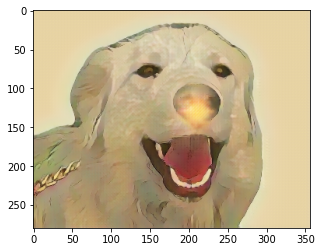

In [2]:
# import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, InputSpec
import PIL
# import sys
# import glob
# import imageio
# import logging
# import argparse
# from tqdm import tqdm
# from datetime import datetime
import cv2
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import torch
from torchvision import transforms, models

image_path = '/content/drive/MyDrive/LimnPet_project/dog_7928.jpg' # 인풋이미지 경로
style = 'hayao' # 원하는 스타일명 지정
    # STYLES = ["shinkai", "hayao", "hosoda", "paprika"] or others(직접학습시킨 경우, 각각 이름 지정해주고 코드수정하면됨)

# segmentation
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
cmap = plt.cm.get_cmap('tab20c')
colors = (cmap(np.arange(cmap.N)) * 255).astype(int)[:, :3].tolist()
np.random.seed(2020)
# np.random.shuffle(colors)
colors.insert(0, [0, 0, 0]) # background color must be black
colors = np.array(colors, dtype=np.uint8)
# palette_map = np.empty((10, 0, 3), dtype=np.uint8)
# legend = []
# for i in range(21):
#     legend.append(mpatches.Patch(color=np.array(colors[i]) / 255., label='%d: %s' % (i, labels[i])))
#     c = np.full((10, 10, 3), colors[i], dtype=np.uint8)
#     palette_map = np.concatenate([palette_map, c], axis=1)

# segmentation 함수 정의
def segment(net, img):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    output = model(input_batch)['out'][0] # (21, height, width)

    output_predictions = output.argmax(0).byte().cpu().numpy() # (height, width) 

    r = PIL.Image.fromarray(output_predictions).resize((img.shape[1], img.shape[0]))
    r.putpalette(colors)

    return r, output_predictions

img = np.array(PIL.Image.open(image_path))
fg_h, fg_w, _ = img.shape
segment_map, pred = segment(model, img)
background = np.ones((fg_h, fg_w, 3))*255.0
mask = (pred == 12).astype(float) * 255 # 12: dog
_, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)
alpha = alpha / 255. # (height, width)
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)
foreground = cv2.multiply(alpha, img.astype(float))
background = cv2.multiply(1. - alpha, background.astype(float))  
result = cv2.add(foreground, background).astype(np.uint8)

# cartonGAN
# pretrained 모델의 load에 필요한 부분
class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=3,
                 epsilon=1e-9,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = tf.keras.initializers.get(beta_initializer)
        self.gamma_initializer = tf.keras.initializers.get(gamma_initializer)
        self.beta_regularizer = tf.keras.regularizers.get(beta_regularizer)
        self.gamma_regularizer = tf.keras.regularizers.get(gamma_regularizer)
        self.beta_constraint = tf.keras.constraints.get(beta_constraint)
        self.gamma_constraint = tf.keras.constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = tf.keras.layers.InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = tf.keras.backend.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = tf.keras.backend.mean(inputs, reduction_axes, keepdims=True)
        stddev = tf.keras.backend.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = tf.keras.backend.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = tf.keras.backend.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': tf.keras.initializers.serialize(self.beta_initializer),
            'gamma_initializer': tf.keras.initializers.serialize(self.gamma_initializer),
            'beta_regularizer': tf.keras.regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': tf.keras.regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': tf.keras.constraints.serialize(self.beta_constraint),
            'gamma_constraint': tf.keras.constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


# ref: https://stackoverflow.com/a/53349976/2447655
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3]

    def call(self, x):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], 'REFLECT')


def conv_layer(style, name, filters, kernel_size, strides=(1, 1), bias=True):
    init_weight = np.load(f"{PRETRAINED_WEIGHT_DIR}/{style}/{name}.weight.npy")
    init_weight = np.transpose(init_weight, [2, 3, 1, 0])
    init_bias = np.load(f"{PRETRAINED_WEIGHT_DIR}/{style}/{name}.bias.npy")

    if bias:
        bias_initializer = tf.keras.initializers.constant(init_bias)
    else:
        bias_initializer = "zeros"

    layer = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        kernel_initializer=tf.keras.initializers.constant(init_weight),
        bias_initializer=bias_initializer
    )
    return layer


def instance_norm_layer(style, name, epsilon=1e-9):
    init_beta = np.load(f"{PRETRAINED_WEIGHT_DIR}/{style}/{name}.shift.npy")
    init_gamma = np.load(f"{PRETRAINED_WEIGHT_DIR}/{style}/{name}.scale.npy")

    layer = InstanceNormalization(
        axis=-1,
        epsilon=epsilon,
        beta_initializer=tf.keras.initializers.Constant(init_beta),
        gamma_initializer=tf.keras.initializers.Constant(init_gamma)
    )
    return layer


def deconv_layers(style, name, filters, kernel_size, strides=(1, 1)):
    init_weight = np.load(f"{PRETRAINED_WEIGHT_DIR}/{style}/{name}.weight.npy")
    init_weight = np.transpose(init_weight, [2, 3, 1, 0])
    init_bias = np.load(f"{PRETRAINED_WEIGHT_DIR}/{style}/{name}.bias.npy")

    layers = list()
    layers.append(tf.keras.layers.Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        kernel_initializer=tf.keras.initializers.constant(init_weight),
        bias_initializer=tf.keras.initializers.constant(init_bias)
    ))

    layers.append(tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0))))
    return layers


def load_model(style):
    inputs = tf.keras.Input(shape=(None, None, 3))

    # y = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(inputs)
    y = ReflectionPadding2D(padding=(3, 3))(inputs)
    y = conv_layer(style, "conv01_1", filters=64, kernel_size=7)(y)
    y = instance_norm_layer(style, "in01_1")(y)
    y = tf.keras.layers.Activation("relu")(y)

    # y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = ReflectionPadding2D(padding=(1, 1))(y)
    y = conv_layer(style, "conv02_1", filters=128, kernel_size=3, strides=(2, 2))(y)
    # y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = ReflectionPadding2D(padding=(1, 1))(y)
    y = conv_layer(style, "conv02_2", filters=128, kernel_size=3, strides=(1, 1))(y)
    y = instance_norm_layer(style, "in02_1")(y)
    y = tf.keras.layers.Activation("relu")(y)

    # y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = ReflectionPadding2D(padding=(1, 1))(y)
    y = conv_layer(style, "conv03_1", filters=256, kernel_size=3, strides=(2, 2))(y)
    # y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = ReflectionPadding2D(padding=(1, 1))(y)
    y = conv_layer(style, "conv03_2", filters=256, kernel_size=3, strides=(1, 1))(y)
    y = instance_norm_layer(style, "in03_1")(y)

    t_prev = tf.keras.layers.Activation("relu")(y)

    for i in range(4, 12):
        # y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(t_prev)
        y = ReflectionPadding2D(padding=(1, 1))(t_prev)
        y = conv_layer(style, "conv%02d_1" % i, filters=256, kernel_size=3)(y)
        y = instance_norm_layer(style, "in%02d_1" % i)(y)
        y = tf.keras.layers.Activation("relu")(y)

        t = ReflectionPadding2D(padding=(1, 1))(y)
        t = conv_layer(style, "conv%02d_2" % i, filters=256, kernel_size=3)(t)
        t = instance_norm_layer(style, "in%02d_2" % i)(t)

        t_prev = tf.keras.layers.Add()([t, t_prev])

        if i == 11:
            y = t_prev

    layers = deconv_layers(style, "deconv01_1", filters=128, kernel_size=3, strides=(2, 2))
    for layer in layers:
        y = layer(y)
    # y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = ReflectionPadding2D(padding=(1, 1))(y)
    y = conv_layer(style, "deconv01_2", filters=128, kernel_size=3)(y)
    y = instance_norm_layer(style, "in12_1")(y)
    y = tf.keras.layers.Activation("relu")(y)

    layers = deconv_layers(style, "deconv02_1", filters=64, kernel_size=3, strides=(2, 2))
    for layer in layers:
        y = layer(y)
    # y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = ReflectionPadding2D(padding=(1, 1))(y)
    y = conv_layer(style, "deconv02_2", filters=64, kernel_size=3)(y)
    y = instance_norm_layer(style, "in13_1")(y)
    y = tf.keras.layers.Activation("relu")(y)

    # y = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(y)
    y = ReflectionPadding2D(padding=(3, 3))(y)
    y = conv_layer(style, "deconv03_1", filters=3, kernel_size=7)(y)
    y = tf.keras.layers.Activation("tanh")(y)

    model = tf.keras.Model(inputs=inputs, outputs=y)

    return model
  
# pretrained 모델을 이용할 경우 아래 실행
if (style == "shinkai") | (style == "hayao") | (style == "hosoda") | (style == "paprika"):
    PRETRAINED_WEIGHT_DIR = '/content/drive/MyDrive/multi_final_project/integrated_exceptRealesrGAN/cartoongan/pretrained_weights' # 저장된 pretrained 모델 가중치 파일 경로
    # image_path = '/content/drive/MyDrive/final_project_sjh/Semantic_segmentation/result.jpg'
    # STYLES = ["shinkai", "hayao", "hosoda", "paprika"]
    cartoonGAN_model = load_model(style)
    input_image = result
    # input_image = cv2.imread(image_path)
    input_image = np.expand_dims(input_image, axis=0)
    output_image = cartoonGAN_model.predict(input_image)
    output_image = output_image[0]
    output_image = output_image[:,:,[2,1,0]]
    output_image = output_image * 0.5 + 0.5
    plt.imshow(output_image)

# 직접 학습한 모델 이용할 경우 아래 실행(모델 수나 경로에 맞춰 수정 필요)
else : 
    model_dir = '/content/drive/MyDrive/multi_final_project/integrated_exceptRealesrGAN/saved_model' # 저장한 모델 디렉토리 경로
    model = tf.saved_model.load(model_dir)
    f = model.signatures["serving_default"]
    input_image = result
    # img = np.array(PIL.Image.open(image_path).convert("RGB"))
    input_image = np.expand_dims(input_image, 0).astype(np.float32) / 127.5 - 1
    output_image = f(tf.constant(input_image))['output_1']
    output_image = ((output_image.numpy().squeeze() + 1) * 127.5).astype(np.uint8)
    plt.imshow(output_image)